# RAG Experimental Results Evaluation

This notebook evaluates experimental results from the RAG (Retrieval-Augmented Generation) system across multiple configurations and datasets (MMLU and TruthfulQA). It includes comprehensive tables and visualizations for performance comparison.

## 1. Import Required Libraries

In [ ]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Define output directory
outputs_dir = Path('outputs')

## 2. Load Data from outputs/

In [ ]:
def load_evaluation_results(dataset_name):
    """Load evaluation results for a specific dataset"""
    dataset_path = outputs_dir / dataset_name
    
    if not dataset_path.exists():
        print(f"Dataset path not found: {dataset_path}")
        return None, None
    
    # Find the latest run directory
    run_dirs = sorted([d for d in dataset_path.iterdir() if d.is_dir()])
    if not run_dirs:
        print(f"No run directories found in {dataset_path}")
        return None, None
    
    latest_run = run_dirs[-1]
    
    # Load eval_results_all.json
    eval_results_path = latest_run / 'eval_results_all.json'
    
    if eval_results_path.exists():
        with open(eval_results_path, 'r') as f:
            eval_results = json.load(f)
        print(f"✓ Loaded evaluation results for {dataset_name} from {latest_run.name}")
        return eval_results, latest_run.name
    else:
        print(f"Evaluation results file not found: {eval_results_path}")
        return None, None

# Load data for both datasets
print("Loading evaluation results...")
mmlu_results, mmlu_run = load_evaluation_results('mmlu')
truthfulqa_results, truthfulqa_run = load_evaluation_results('truthfulqa')

Loading evaluation results...
✓ Loaded evaluation results for mmlu from runtest_suite_01-12_05-38
✓ Loaded evaluation results for truthfulqa from runtest_suite_01-11_12-00


## 3. Prepare Data for Analysis

In [ ]:
def prepare_dataframe(results_dict, dataset_name):
    """Convert results dictionary to DataFrame"""
    metrics_data = []
    timing_data = []
    
    for config_name, config_results in results_dict.items():
        # Extract configuration number and name
        config_num = config_name.split('_')[0]
        config_display = config_name.replace('_', ' ')
        
        # Prepare metrics row
        metrics_row = {
            'Configuration': config_display,
            'Config_Num': int(config_num),
            'Dataset': dataset_name,
            'R1-F1': config_results.get('r1f1', 0),
            'R2-F1': config_results.get('r2f1', 0),
            'RL-F1': config_results.get('rLf1', 0),
            'Similarity': config_results.get('similarity', 0),
            'MAUVE': config_results.get('mauve', 0)
        }
        metrics_data.append(metrics_row)
        
        # Prepare timing row
        timing_info = config_results.get('timing', {})
        timing_row = {
            'Configuration': config_display,
            'Config_Num': int(config_num),
            'Dataset': dataset_name,
            'Model Load (s)': timing_info.get('model_load_time', 0),
            'RAG Init (s)': timing_info.get('rag_init_time', 0),
            'Evaluation (s)': timing_info.get('evaluation_time', 0),
            'Total Time (s)': timing_info.get('total_time', 0)
        }
        timing_data.append(timing_row)
    
    metrics_df = pd.DataFrame(metrics_data).sort_values('Config_Num')
    timing_df = pd.DataFrame(timing_data).sort_values('Config_Num')
    
    return metrics_df, timing_df

# Prepare DataFrames for both datasets
if mmlu_results:
    mmlu_metrics, mmlu_timing = prepare_dataframe(mmlu_results, 'MMLU')
else:
    mmlu_metrics, mmlu_timing = None, None

if truthfulqa_results:
    tqa_metrics, tqa_timing = prepare_dataframe(truthfulqa_results, 'TruthfulQA')
else:
    tqa_metrics, tqa_timing = None, None

# Combine data for comparison
if mmlu_metrics is not None and tqa_metrics is not None:
    combined_metrics = pd.concat([mmlu_metrics, tqa_metrics], ignore_index=True)
    combined_timing = pd.concat([mmlu_timing, tqa_timing], ignore_index=True)
    print("✓ Data preparation complete")
else:
    print("⚠ Some datasets could not be loaded")

✓ Data preparation complete


## 4. MMLU Dataset - Metrics Summary

In [ ]:
if mmlu_metrics is not None:
    print("MMLU Evaluation Metrics:")
    print(mmlu_metrics[['Configuration', 'R1-F1', 'R2-F1', 'RL-F1', 'Similarity', 'MAUVE']].to_string(index=False))
    print("\n" + "="*80)
    print("MMLU Timing Summary (seconds):")
    print(mmlu_timing[['Configuration', 'Model Load (s)', 'RAG Init (s)', 'Evaluation (s)', 'Total Time (s)']].to_string(index=False))

MMLU Evaluation Metrics:
        Configuration    R1-F1    R2-F1    RL-F1  Similarity    MAUVE
           1 Baseline 0.102067 0.018875 0.086987    0.288093 0.650242
   2 ExpandQuery Only 0.103964 0.021117 0.089310    0.292637 0.621005
         3 Focus Only 0.100998 0.020088 0.087047    0.291322 0.363633
           4 ICL Only 0.106762 0.023867 0.092060    0.304393 0.540717
  5 ExpandQuery Focus 0.101288 0.019592 0.086478    0.288999 0.602832
          6 Focus ICL 0.112968 0.024200 0.096576    0.314140 0.405783
7 Hybrid All Features 0.097261 0.021013 0.084298    0.286901 0.488429

MMLU Timing Summary (seconds):
        Configuration  Model Load (s)  RAG Init (s)  Evaluation (s)  Total Time (s)
           1 Baseline       77.270450    185.056901     4979.502032     5244.107543
   2 ExpandQuery Only       37.885353    183.860478     5792.679857     6016.670409
         3 Focus Only       32.053112    183.403954     5561.615606     5779.425690
           4 ICL Only       41.089453      4.77

## 5. TruthfulQA Dataset - Metrics Summary

In [ ]:
if tqa_metrics is not None:
    print("TruthfulQA Evaluation Metrics:")
    print(tqa_metrics[['Configuration', 'R1-F1', 'R2-F1', 'RL-F1', 'Similarity', 'MAUVE']].to_string(index=False))
    print("\n" + "="*80)
    print("TruthfulQA Timing Summary (seconds):")
    print(tqa_timing[['Configuration', 'Model Load (s)', 'RAG Init (s)', 'Evaluation (s)', 'Total Time (s)']].to_string(index=False))

TruthfulQA Evaluation Metrics:
        Configuration    R1-F1    R2-F1    RL-F1  Similarity    MAUVE
           1 Baseline 0.256163 0.119499 0.226524    0.558942 0.493339
   2 ExpandQuery Only 0.260440 0.120760 0.228625    0.566744 0.472552
         3 Focus Only 0.263094 0.123644 0.231971    0.566349 0.501323
           4 ICL Only 0.272608 0.144381 0.242846    0.537927 0.295868
  5 ExpandQuery Focus 0.253822 0.114798 0.222802    0.552827 0.378986
          6 Focus ICL 0.274500 0.130573 0.242221    0.579469 0.418705
7 Hybrid All Features 0.382330 0.275548 0.361063    0.633170 0.460376

TruthfulQA Timing Summary (seconds):
        Configuration  Model Load (s)  RAG Init (s)  Evaluation (s)  Total Time (s)
           1 Baseline       65.335444    160.101824     1454.779519     1682.120388
   2 ExpandQuery Only       58.255496    154.752594     1522.943770     1737.872345
         3 Focus Only       44.734643    153.020056     1673.015917     1872.723377
           4 ICL Only       62.7167

## 6. Comparison Charts - ROUGE Metrics

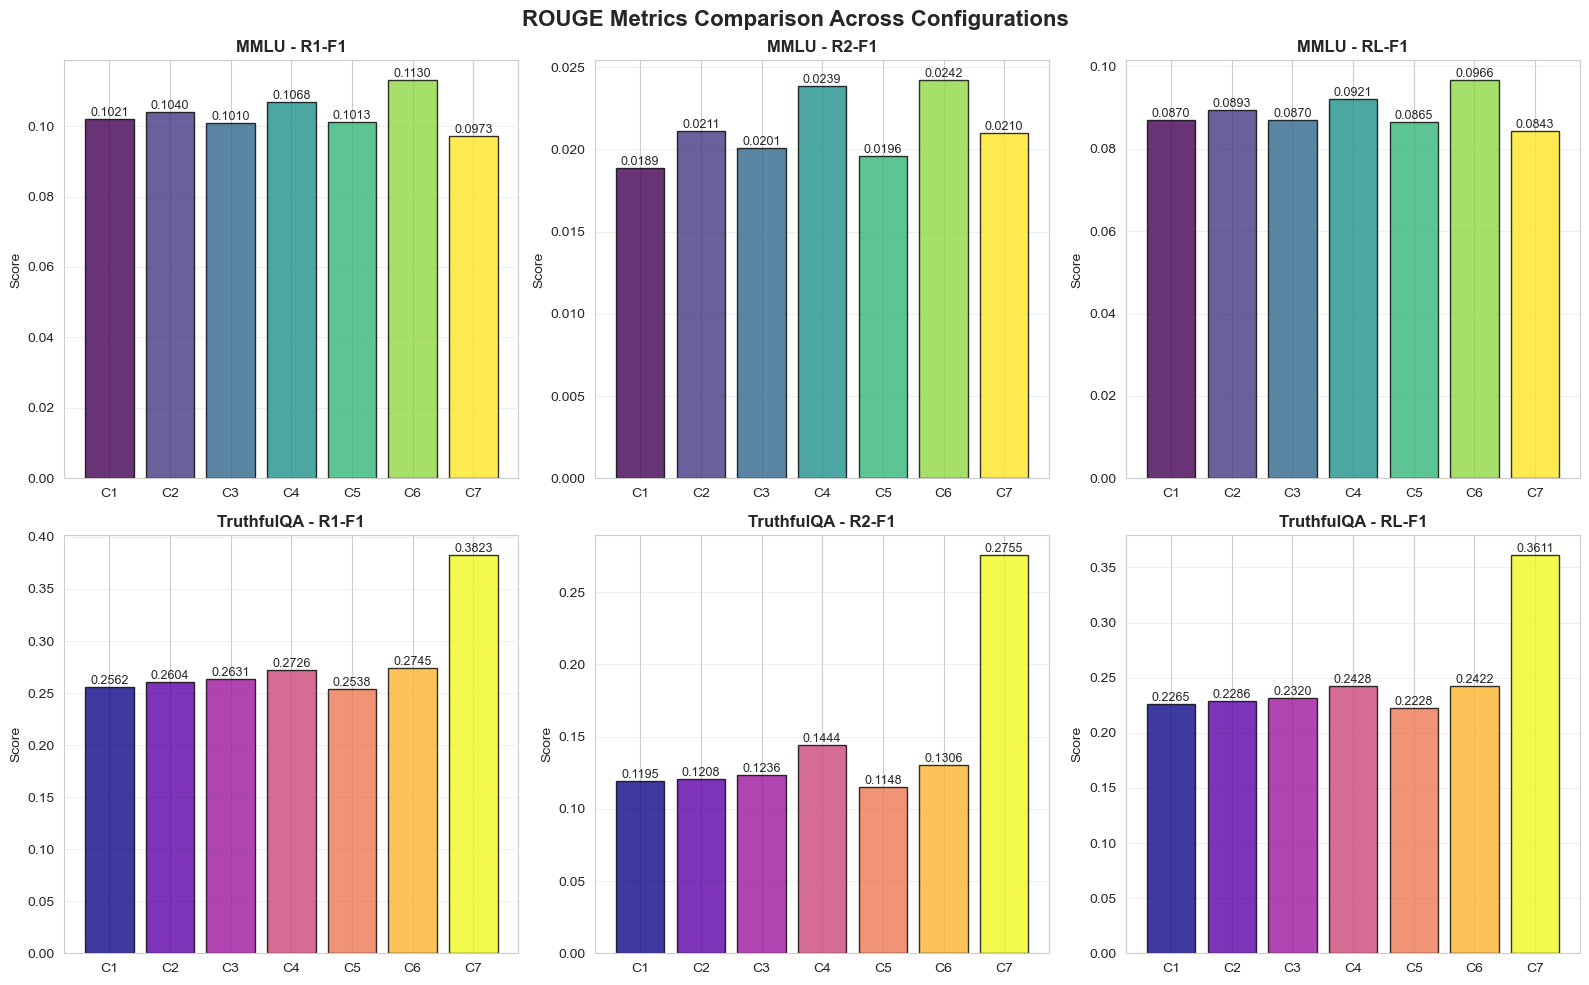

✓ ROUGE metrics comparison chart saved as 'rouge_metrics_comparison.png'


In [ ]:
if mmlu_metrics is not None and tqa_metrics is not None:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle('ROUGE Metrics Comparison Across Configurations', fontsize=16, fontweight='bold')
    
    rouge_metrics = ['R1-F1', 'R2-F1', 'RL-F1']
    
    for idx, metric in enumerate(rouge_metrics):
        # MMLU
        ax = axes[0, idx]
        colors = plt.cm.viridis(np.linspace(0, 1, len(mmlu_metrics)))
        bars = ax.bar(range(len(mmlu_metrics)), mmlu_metrics[metric], color=colors, alpha=0.8, edgecolor='black')
        ax.set_title(f'MMLU - {metric}', fontweight='bold')
        ax.set_ylabel('Score')
        ax.set_xticks(range(len(mmlu_metrics)))
        ax.set_xticklabels([f"C{i+1}" for i in range(len(mmlu_metrics))], rotation=0)
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=9)
        
        # TruthfulQA
        ax = axes[1, idx]
        colors = plt.cm.plasma(np.linspace(0, 1, len(tqa_metrics)))
        bars = ax.bar(range(len(tqa_metrics)), tqa_metrics[metric], color=colors, alpha=0.8, edgecolor='black')
        ax.set_title(f'TruthfulQA - {metric}', fontweight='bold')
        ax.set_ylabel('Score')
        ax.set_xticks(range(len(tqa_metrics)))
        ax.set_xticklabels([f"C{i+1}" for i in range(len(tqa_metrics))], rotation=0)
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('rouge_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ ROUGE metrics comparison chart saved as 'rouge_metrics_comparison.png'")

## 7. Comparison Charts - Similarity and MAUVE

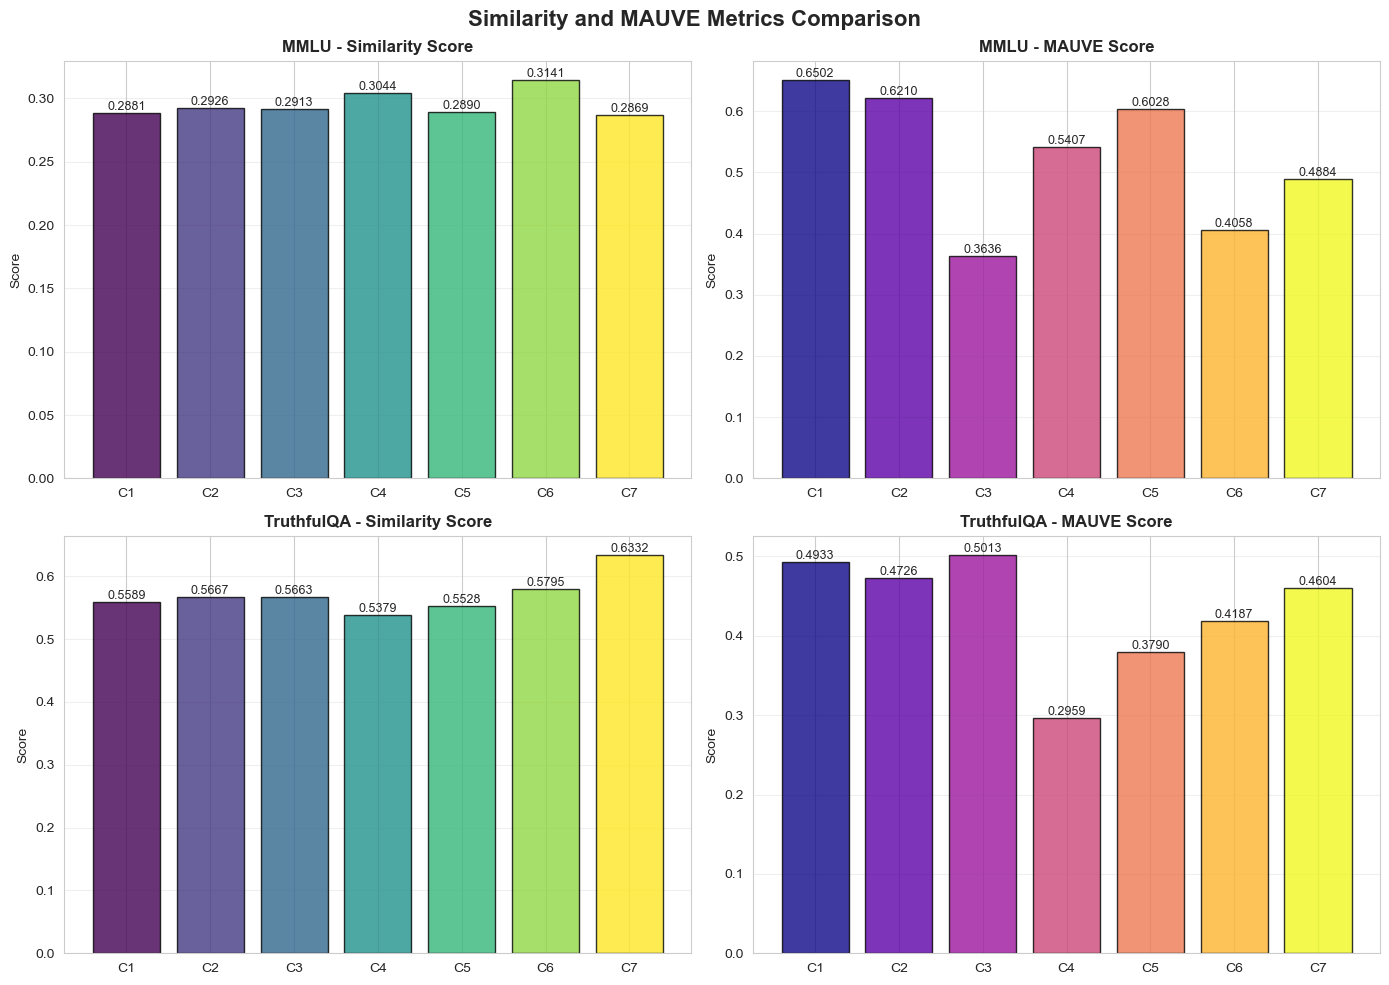

✓ Similarity and MAUVE comparison chart saved as 'similarity_mauve_comparison.png'


In [ ]:
if mmlu_metrics is not None and tqa_metrics is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Similarity and MAUVE Metrics Comparison', fontsize=16, fontweight='bold')
    
    # MMLU - Similarity
    ax = axes[0, 0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(mmlu_metrics)))
    bars = ax.bar(range(len(mmlu_metrics)), mmlu_metrics['Similarity'], color=colors, alpha=0.8, edgecolor='black')
    ax.set_title('MMLU - Similarity Score', fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_xticks(range(len(mmlu_metrics)))
    ax.set_xticklabels([f"C{i+1}" for i in range(len(mmlu_metrics))], rotation=0)
    ax.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', 
               ha='center', va='bottom', fontsize=9)
    
    # MMLU - MAUVE
    ax = axes[0, 1]
    colors = plt.cm.plasma(np.linspace(0, 1, len(mmlu_metrics)))
    bars = ax.bar(range(len(mmlu_metrics)), mmlu_metrics['MAUVE'], color=colors, alpha=0.8, edgecolor='black')
    ax.set_title('MMLU - MAUVE Score', fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_xticks(range(len(mmlu_metrics)))
    ax.set_xticklabels([f"C{i+1}" for i in range(len(mmlu_metrics))], rotation=0)
    ax.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', 
               ha='center', va='bottom', fontsize=9)
    
    # TruthfulQA - Similarity
    ax = axes[1, 0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(tqa_metrics)))
    bars = ax.bar(range(len(tqa_metrics)), tqa_metrics['Similarity'], color=colors, alpha=0.8, edgecolor='black')
    ax.set_title('TruthfulQA - Similarity Score', fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_xticks(range(len(tqa_metrics)))
    ax.set_xticklabels([f"C{i+1}" for i in range(len(tqa_metrics))], rotation=0)
    ax.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', 
               ha='center', va='bottom', fontsize=9)
    
    # TruthfulQA - MAUVE
    ax = axes[1, 1]
    colors = plt.cm.plasma(np.linspace(0, 1, len(tqa_metrics)))
    bars = ax.bar(range(len(tqa_metrics)), tqa_metrics['MAUVE'], color=colors, alpha=0.8, edgecolor='black')
    ax.set_title('TruthfulQA - MAUVE Score', fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_xticks(range(len(tqa_metrics)))
    ax.set_xticklabels([f"C{i+1}" for i in range(len(tqa_metrics))], rotation=0)
    ax.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', 
               ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('similarity_mauve_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Similarity and MAUVE comparison chart saved as 'similarity_mauve_comparison.png'")

## 8. Timing Analysis

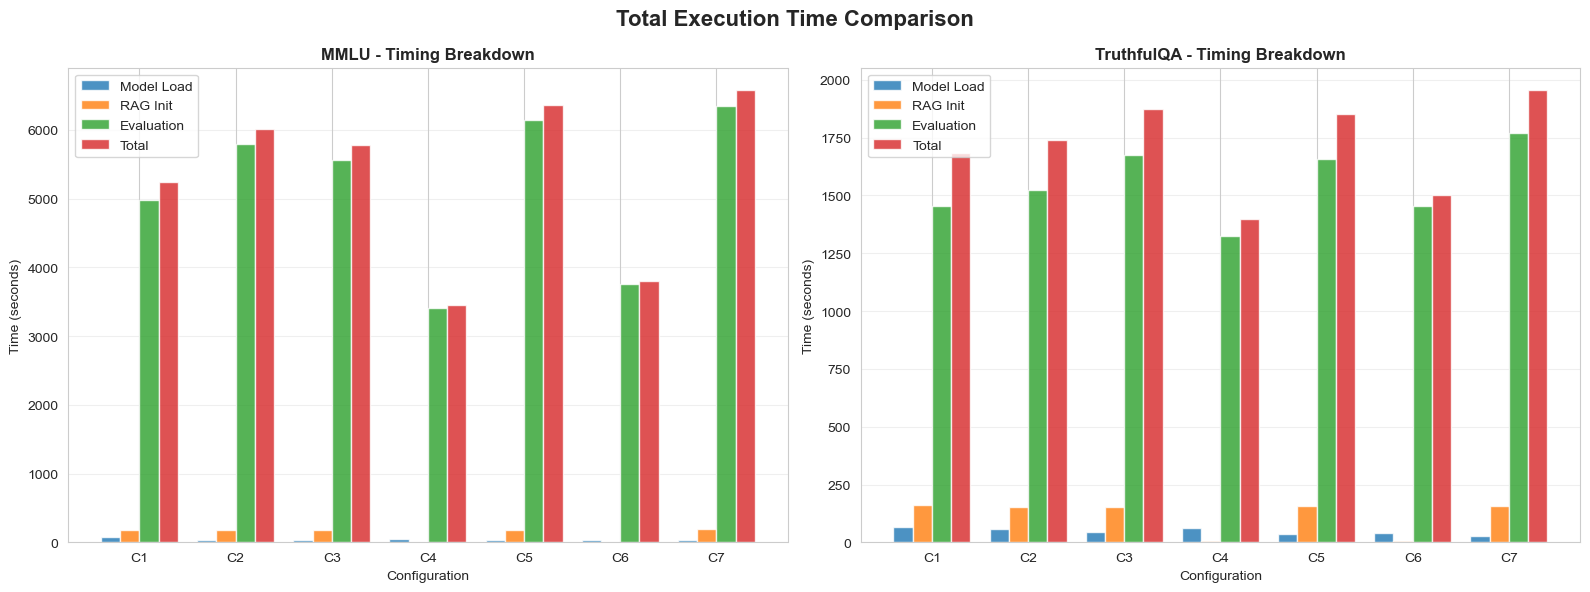

✓ Timing analysis chart saved as 'timing_analysis.png'


In [ ]:
if mmlu_metrics is not None and tqa_metrics is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Total Execution Time Comparison', fontsize=16, fontweight='bold')
    
    # MMLU Timing
    ax = axes[0]
    x_pos = np.arange(len(mmlu_timing))
    width = 0.2
    
    rects1 = ax.bar(x_pos - 1.5*width, mmlu_timing['Model Load (s)'], width, label='Model Load', alpha=0.8)
    rects2 = ax.bar(x_pos - 0.5*width, mmlu_timing['RAG Init (s)'], width, label='RAG Init', alpha=0.8)
    rects3 = ax.bar(x_pos + 0.5*width, mmlu_timing['Evaluation (s)'], width, label='Evaluation', alpha=0.8)
    rects4 = ax.bar(x_pos + 1.5*width, mmlu_timing['Total Time (s)'], width, label='Total', alpha=0.8)
    
    ax.set_title('MMLU - Timing Breakdown', fontweight='bold')
    ax.set_ylabel('Time (seconds)')
    ax.set_xlabel('Configuration')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"C{i+1}" for i in range(len(mmlu_timing))], rotation=0)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # TruthfulQA Timing
    ax = axes[1]
    x_pos = np.arange(len(tqa_timing))
    width = 0.2
    
    rects1 = ax.bar(x_pos - 1.5*width, tqa_timing['Model Load (s)'], width, label='Model Load', alpha=0.8)
    rects2 = ax.bar(x_pos - 0.5*width, tqa_timing['RAG Init (s)'], width, label='RAG Init', alpha=0.8)
    rects3 = ax.bar(x_pos + 0.5*width, tqa_timing['Evaluation (s)'], width, label='Evaluation', alpha=0.8)
    rects4 = ax.bar(x_pos + 1.5*width, tqa_timing['Total Time (s)'], width, label='Total', alpha=0.8)
    
    ax.set_title('TruthfulQA - Timing Breakdown', fontweight='bold')
    ax.set_ylabel('Time (seconds)')
    ax.set_xlabel('Configuration')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"C{i+1}" for i in range(len(tqa_timing))], rotation=0)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('timing_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Timing analysis chart saved as 'timing_analysis.png'")

## 9. Comprehensive Dashboard - All Metrics

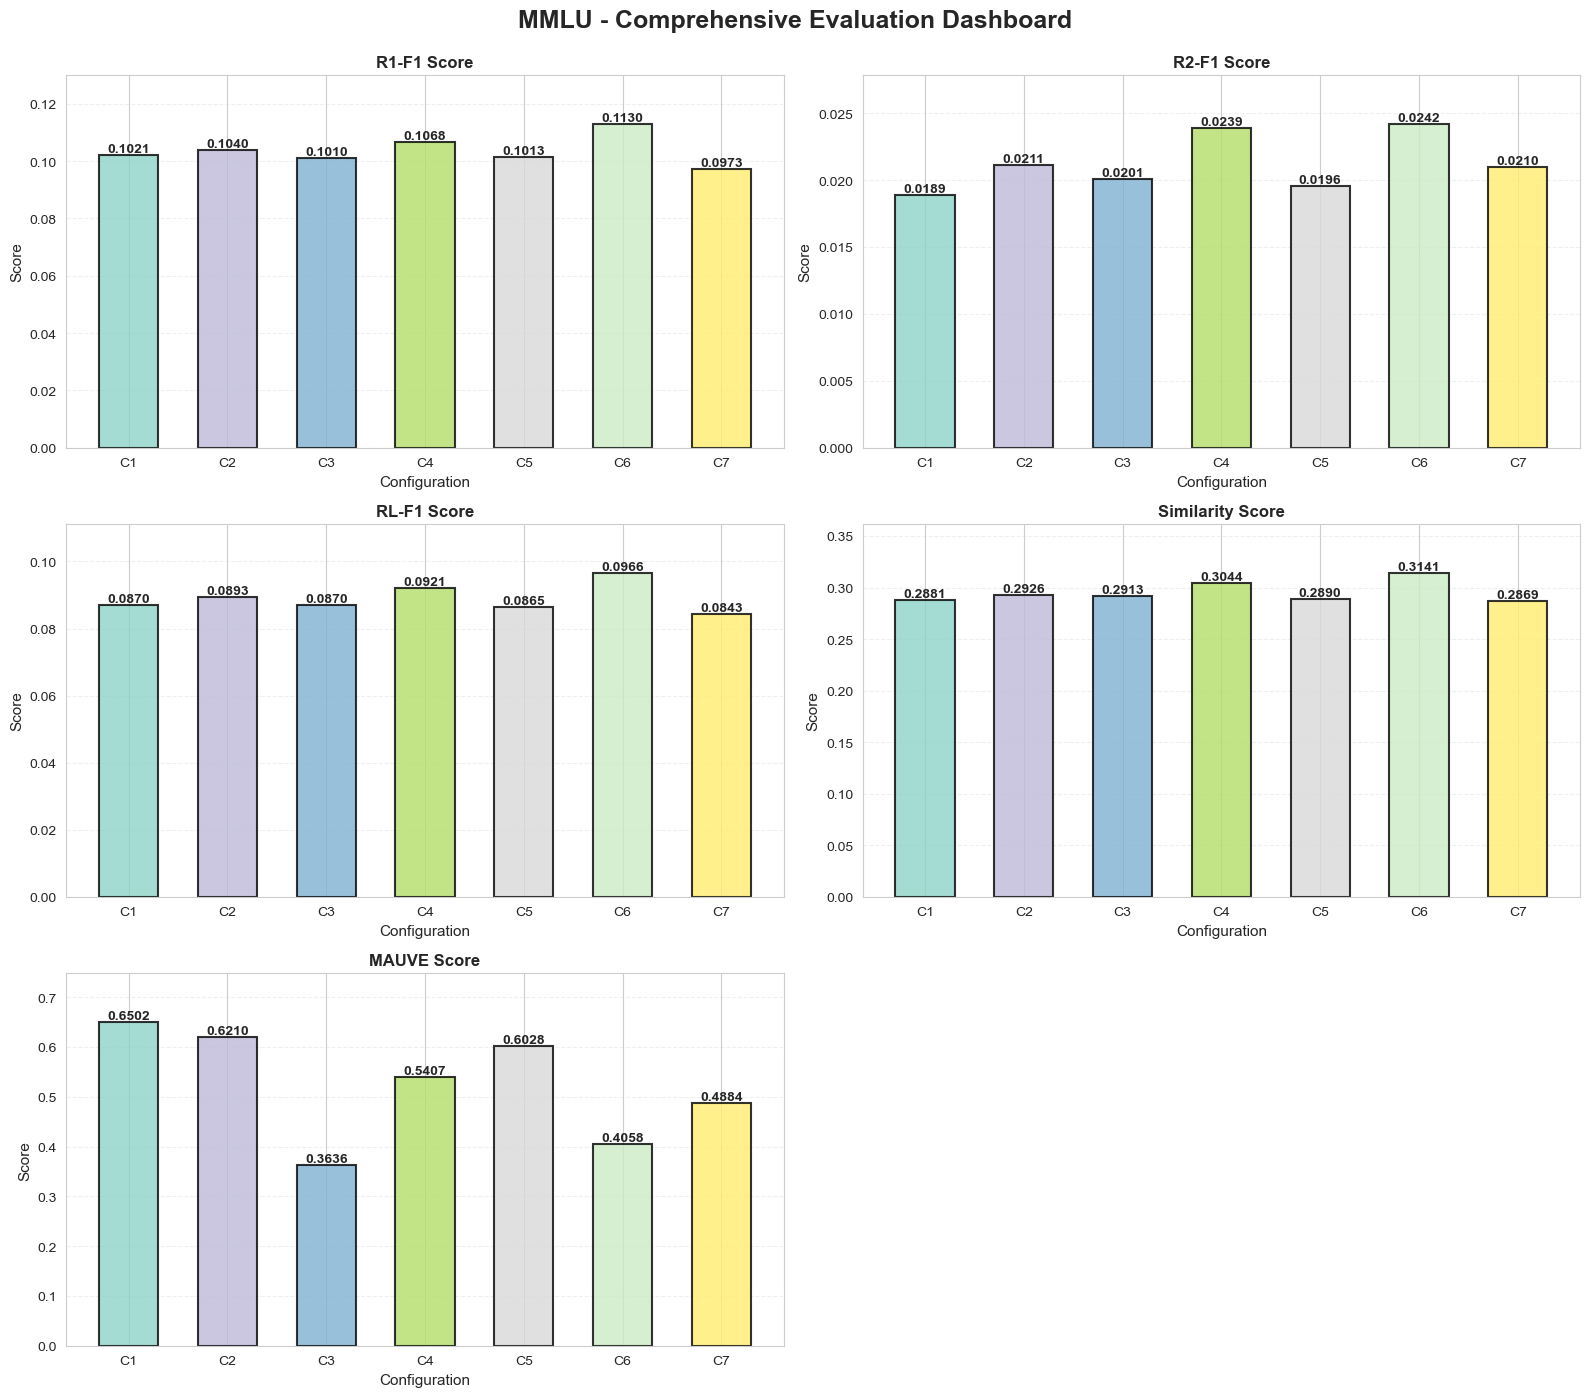

✓ MMLU comprehensive dashboard saved as 'mmlu_comprehensive_dashboard.png'


In [ ]:
if mmlu_metrics is not None:
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('MMLU - Comprehensive Evaluation Dashboard', fontsize=18, fontweight='bold', y=0.995)
    
    metrics_to_plot = ['R1-F1', 'R2-F1', 'RL-F1', 'Similarity', 'MAUVE']
    colors = plt.cm.Set3(np.linspace(0, 1, len(mmlu_metrics)))
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        x = np.arange(len(mmlu_metrics))
        width = 0.6
        bars = ax.bar(x, mmlu_metrics[metric], width, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', 
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        ax.set_title(f'{metric} Score', fontweight='bold', fontsize=12)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_xlabel('Configuration', fontsize=11)
        ax.set_xticks(x)
        ax.set_xticklabels([f"C{i+1}" for i in range(len(mmlu_metrics))], rotation=0)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_ylim([0, max(mmlu_metrics[metric]) * 1.15])
    
    # Remove extra subplot
    fig.delaxes(axes[2, 1])
    
    plt.tight_layout()
    plt.savefig('mmlu_comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ MMLU comprehensive dashboard saved as 'mmlu_comprehensive_dashboard.png'")

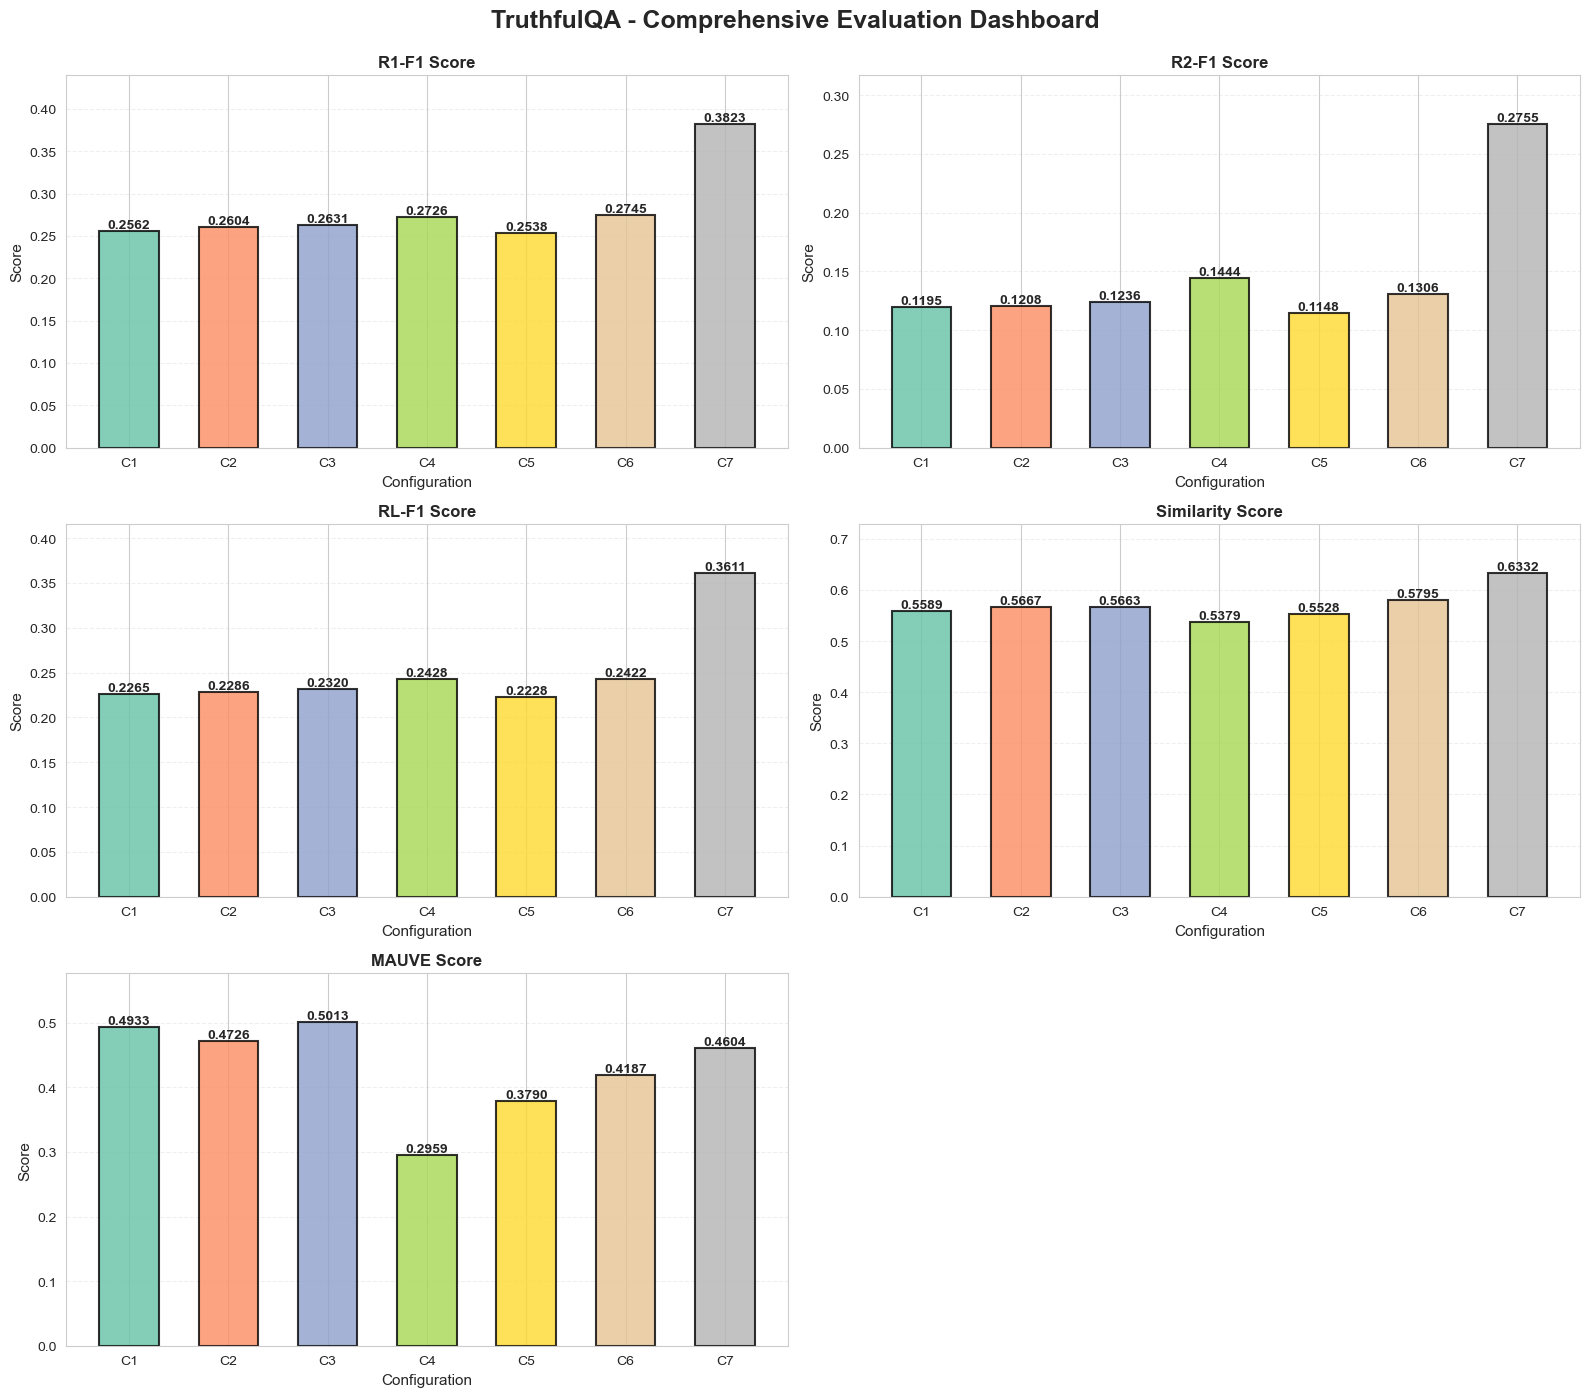

✓ TruthfulQA comprehensive dashboard saved as 'truthfulqa_comprehensive_dashboard.png'


In [ ]:
if tqa_metrics is not None:
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('TruthfulQA - Comprehensive Evaluation Dashboard', fontsize=18, fontweight='bold', y=0.995)
    
    metrics_to_plot = ['R1-F1', 'R2-F1', 'RL-F1', 'Similarity', 'MAUVE']
    colors = plt.cm.Set2(np.linspace(0, 1, len(tqa_metrics)))
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        x = np.arange(len(tqa_metrics))
        width = 0.6
        bars = ax.bar(x, tqa_metrics[metric], width, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', 
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        ax.set_title(f'{metric} Score', fontweight='bold', fontsize=12)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_xlabel('Configuration', fontsize=11)
        ax.set_xticks(x)
        ax.set_xticklabels([f"C{i+1}" for i in range(len(tqa_metrics))], rotation=0)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_ylim([0, max(tqa_metrics[metric]) * 1.15])
    
    # Remove extra subplot
    fig.delaxes(axes[2, 1])
    
    plt.tight_layout()
    plt.savefig('truthfulqa_comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ TruthfulQA comprehensive dashboard saved as 'truthfulqa_comprehensive_dashboard.png'")

## 10. Heatmap Comparison - Across All Metrics

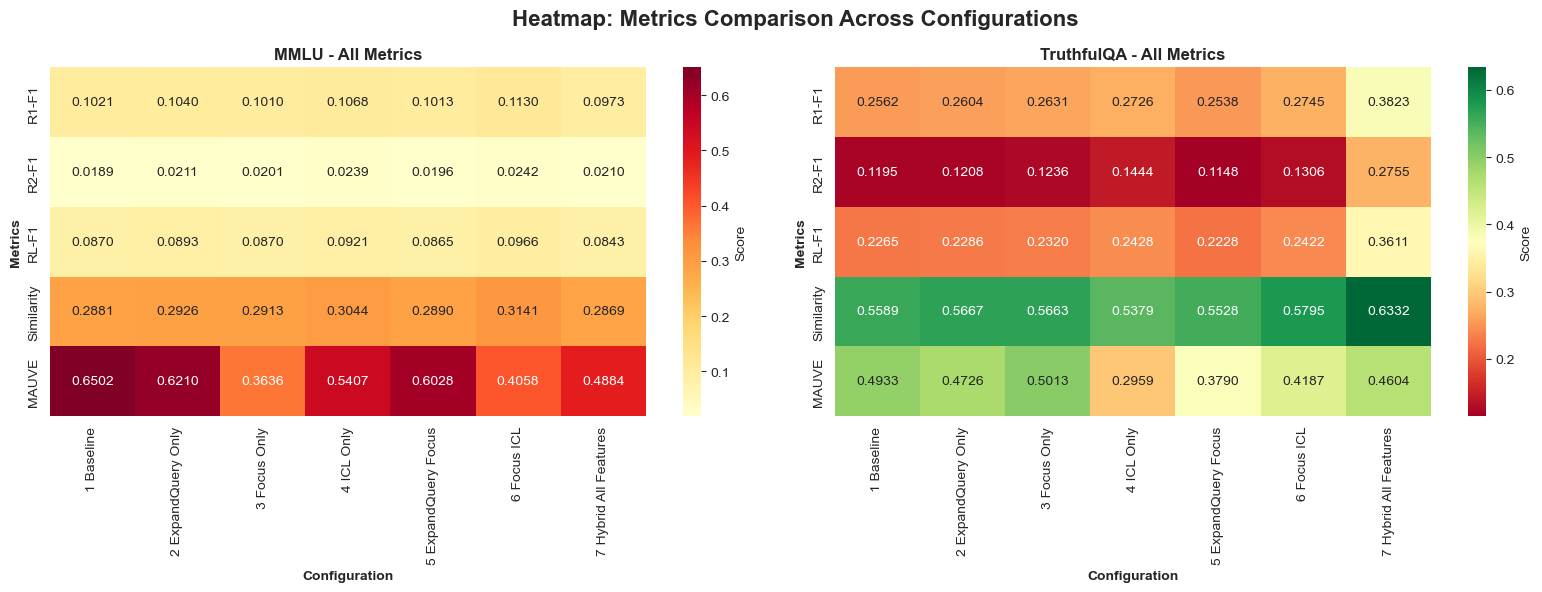

✓ Heatmap comparison saved as 'metrics_heatmap.png'


In [ ]:
if mmlu_metrics is not None and tqa_metrics is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Heatmap: Metrics Comparison Across Configurations', fontsize=16, fontweight='bold')
    
    # Prepare data for MMLU heatmap
    mmlu_heatmap_data = mmlu_metrics[['Configuration', 'R1-F1', 'R2-F1', 'RL-F1', 'Similarity', 'MAUVE']].set_index('Configuration')
    
    # MMLU Heatmap
    ax = axes[0]
    sns.heatmap(mmlu_heatmap_data.T, annot=True, fmt='.4f', cmap='YlOrRd', cbar_kws={'label': 'Score'}, ax=ax)
    ax.set_title('MMLU - All Metrics', fontweight='bold')
    ax.set_ylabel('Metrics', fontweight='bold')
    ax.set_xlabel('Configuration', fontweight='bold')
    
    # Prepare data for TruthfulQA heatmap
    tqa_heatmap_data = tqa_metrics[['Configuration', 'R1-F1', 'R2-F1', 'RL-F1', 'Similarity', 'MAUVE']].set_index('Configuration')
    
    # TruthfulQA Heatmap
    ax = axes[1]
    sns.heatmap(tqa_heatmap_data.T, annot=True, fmt='.4f', cmap='RdYlGn', cbar_kws={'label': 'Score'}, ax=ax)
    ax.set_title('TruthfulQA - All Metrics', fontweight='bold')
    ax.set_ylabel('Metrics', fontweight='bold')
    ax.set_xlabel('Configuration', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('metrics_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Heatmap comparison saved as 'metrics_heatmap.png'")

## 11. Improvement Analysis - % Change from Baseline

In [ ]:
def calculate_improvement(df, dataset_name):
    """Calculate % improvement compared to baseline (Configuration 1)"""
    baseline_values = df[df['Config_Num'] == 1].iloc[0]
    metrics = ['R1-F1', 'R2-F1', 'RL-F1', 'Similarity', 'MAUVE']
    
    improvement_data = []
    for idx, row in df.iterrows():
        improvement_row = {
            'Configuration': row['Configuration'],
            'Config_Num': row['Config_Num']
        }
        for metric in metrics:
            baseline = baseline_values[metric]
            current = row[metric]
            if baseline != 0:
                improvement = ((current - baseline) / baseline) * 100
            else:
                improvement = 0
            improvement_row[f'{metric} (%)'] = improvement
        improvement_data.append(improvement_row)
    
    return pd.DataFrame(improvement_data)

if mmlu_metrics is not None:
    mmlu_improvement = calculate_improvement(mmlu_metrics, 'MMLU')
    print("MMLU - % Change from Baseline (Configuration 1):")
    print(mmlu_improvement[['Configuration', 'R1-F1 (%)', 'R2-F1 (%)', 'RL-F1 (%)', 'Similarity (%)', 'MAUVE (%)']].to_string(index=False))
    print()

if tqa_metrics is not None:
    tqa_improvement = calculate_improvement(tqa_metrics, 'TruthfulQA')
    print("TruthfulQA - % Change from Baseline (Configuration 1):")
    print(tqa_improvement[['Configuration', 'R1-F1 (%)', 'R2-F1 (%)', 'RL-F1 (%)', 'Similarity (%)', 'MAUVE (%)']].to_string(index=False))

MMLU - % Change from Baseline (Configuration 1):
        Configuration  R1-F1 (%)  R2-F1 (%)  RL-F1 (%)  Similarity (%)  MAUVE (%)
           1 Baseline   0.000000   0.000000   0.000000        0.000000   0.000000
   2 ExpandQuery Only   1.858371  11.874459   2.670102        1.577221  -4.496307
         3 Focus Only  -1.047874   6.425270   0.069157        1.120514 -44.077231
           4 ICL Only   4.600157  26.446593   5.832451        5.657813 -16.843710
  5 ExpandQuery Focus  -0.763846   3.799404  -0.585459        0.314364  -7.291232
          6 Focus ICL  10.680214  28.209871  11.024014        9.041049 -37.595071
7 Hybrid All Features  -4.708661  11.323600  -3.090748       -0.413818 -24.885135

TruthfulQA - % Change from Baseline (Configuration 1):
        Configuration  R1-F1 (%)  R2-F1 (%)  RL-F1 (%)  Similarity (%)  MAUVE (%)
           1 Baseline   0.000000   0.000000   0.000000        0.000000   0.000000
   2 ExpandQuery Only   1.669603   1.054906   0.927820        1.395875  -4.

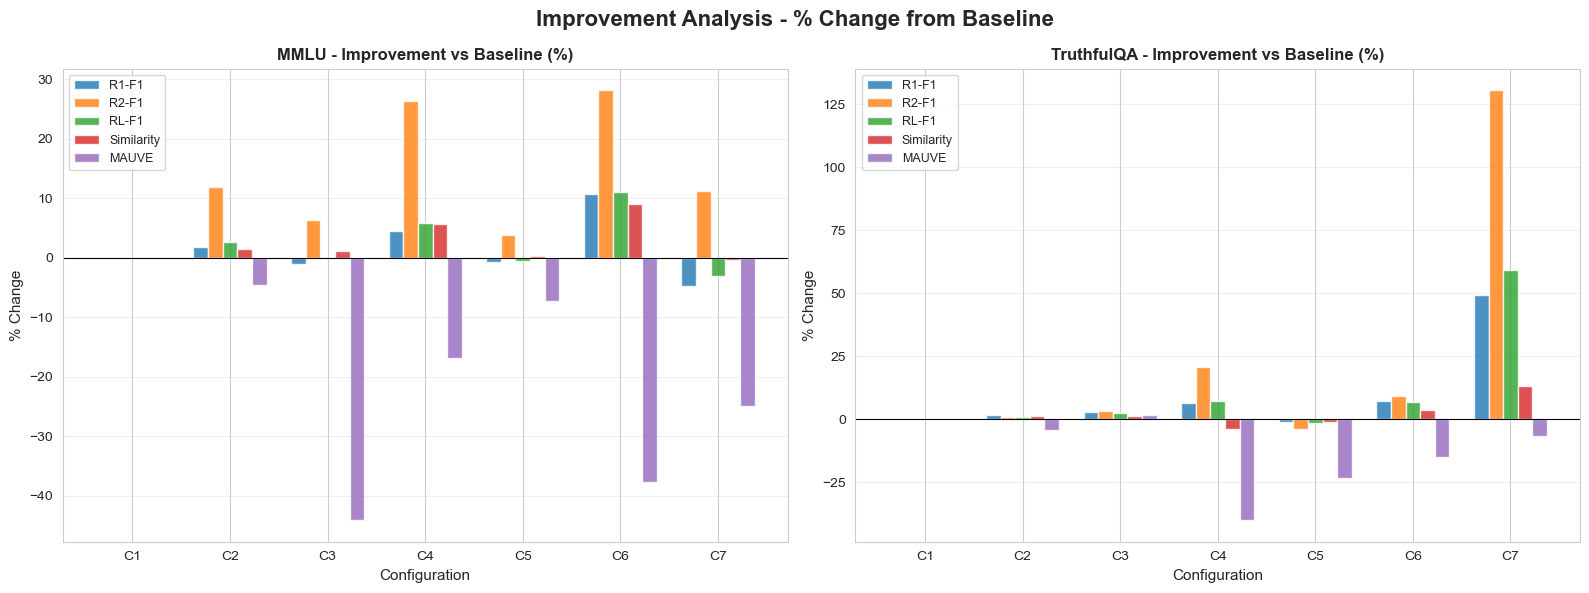

✓ Improvement analysis chart saved as 'improvement_analysis.png'


In [ ]:
if mmlu_metrics is not None and tqa_metrics is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Improvement Analysis - % Change from Baseline', fontsize=16, fontweight='bold')
    
    metrics = ['R1-F1 (%)', 'R2-F1 (%)', 'RL-F1 (%)', 'Similarity (%)', 'MAUVE (%)']
    
    # MMLU Improvement
    ax = axes[0]
    x = np.arange(len(mmlu_improvement))
    width = 0.15
    
    for i, metric in enumerate(metrics):
        offset = (i - 2) * width
        values = mmlu_improvement[metric].values
        colors_arr = ['green' if v >= 0 else 'red' for v in values]
        ax.bar(x + offset, values, width, label=metric.replace(' (%)', ''), alpha=0.8)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_title('MMLU - Improvement vs Baseline (%)', fontweight='bold')
    ax.set_ylabel('% Change', fontsize=11)
    ax.set_xlabel('Configuration', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels([f"C{i+1}" for i in range(len(mmlu_improvement))], rotation=0)
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    
    # TruthfulQA Improvement
    ax = axes[1]
    x = np.arange(len(tqa_improvement))
    width = 0.15
    
    for i, metric in enumerate(metrics):
        offset = (i - 2) * width
        values = tqa_improvement[metric].values
        colors_arr = ['green' if v >= 0 else 'red' for v in values]
        ax.bar(x + offset, values, width, label=metric.replace(' (%)', ''), alpha=0.8)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_title('TruthfulQA - Improvement vs Baseline (%)', fontweight='bold')
    ax.set_ylabel('% Change', fontsize=11)
    ax.set_xlabel('Configuration', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels([f"C{i+1}" for i in range(len(tqa_improvement))], rotation=0)
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('improvement_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Improvement analysis chart saved as 'improvement_analysis.png'")

## 12. Export Results to CSV Files

In [ ]:
# Create output directory for results
results_dir = Path('evaluation_results')
results_dir.mkdir(exist_ok=True)

# Export metrics
if mmlu_metrics is not None:
    mmlu_metrics.to_csv(results_dir / 'mmlu_metrics.csv', index=False)
    print(f"✓ MMLU metrics exported to {results_dir / 'mmlu_metrics.csv'}")

if tqa_metrics is not None:
    tqa_metrics.to_csv(results_dir / 'truthfulqa_metrics.csv', index=False)
    print(f"✓ TruthfulQA metrics exported to {results_dir / 'truthfulqa_metrics.csv'}")

# Export timing data
if mmlu_timing is not None:
    mmlu_timing.to_csv(results_dir / 'mmlu_timing.csv', index=False)
    print(f"✓ MMLU timing exported to {results_dir / 'mmlu_timing.csv'}")

if tqa_timing is not None:
    tqa_timing.to_csv(results_dir / 'truthfulqa_timing.csv', index=False)
    print(f"✓ TruthfulQA timing exported to {results_dir / 'truthfulqa_timing.csv'}")

# Export improvement analysis
if mmlu_metrics is not None:
    mmlu_improvement.to_csv(results_dir / 'mmlu_improvement.csv', index=False)
    print(f"✓ MMLU improvement analysis exported to {results_dir / 'mmlu_improvement.csv'}")

if tqa_metrics is not None:
    tqa_improvement.to_csv(results_dir / 'truthfulqa_improvement.csv', index=False)
    print(f"✓ TruthfulQA improvement analysis exported to {results_dir / 'truthfulqa_improvement.csv'}")

print("\n" + "="*80)
print(f"All results have been exported to '{results_dir}' directory")

✓ MMLU metrics exported to evaluation_results\mmlu_metrics.csv
✓ TruthfulQA metrics exported to evaluation_results\truthfulqa_metrics.csv
✓ MMLU timing exported to evaluation_results\mmlu_timing.csv
✓ TruthfulQA timing exported to evaluation_results\truthfulqa_timing.csv
✓ MMLU improvement analysis exported to evaluation_results\mmlu_improvement.csv
✓ TruthfulQA improvement analysis exported to evaluation_results\truthfulqa_improvement.csv

All results have been exported to 'evaluation_results' directory


## 13. Summary Statistics

In [ ]:
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

if mmlu_metrics is not None:
    print("\nMMLA DATASET - Metrics Statistics:")
    print("-" * 80)
    metrics_cols = ['R1-F1', 'R2-F1', 'RL-F1', 'Similarity', 'MAUVE']
    print(mmlu_metrics[metrics_cols].describe().round(4))
    
    print("\nMMLA DATASET - Best Configuration by Metric:")
    print("-" * 80)
    for col in metrics_cols:
        best_idx = mmlu_metrics[col].idxmax()
        best_config = mmlu_metrics.loc[best_idx, 'Configuration']
        best_value = mmlu_metrics.loc[best_idx, col]
        print(f"  {col:12} -> {best_config:30} ({best_value:.4f})")

if tqa_metrics is not None:
    print("\nTruthfulQA DATASET - Metrics Statistics:")
    print("-" * 80)
    metrics_cols = ['R1-F1', 'R2-F1', 'RL-F1', 'Similarity', 'MAUVE']
    print(tqa_metrics[metrics_cols].describe().round(4))
    
    print("\nTruthfulQA DATASET - Best Configuration by Metric:")
    print("-" * 80)
    for col in metrics_cols:
        best_idx = tqa_metrics[col].idxmax()
        best_config = tqa_metrics.loc[best_idx, 'Configuration']
        best_value = tqa_metrics.loc[best_idx, col]
        print(f"  {col:12} -> {best_config:30} ({best_value:.4f})")

print("\n" + "="*80)
print("Evaluation Complete! All charts have been saved.")
print("="*80)


SUMMARY STATISTICS

MMLA DATASET - Metrics Statistics:
--------------------------------------------------------------------------------
        R1-F1   R2-F1   RL-F1  Similarity   MAUVE
count  7.0000  7.0000  7.0000      7.0000  7.0000
mean   0.1036  0.0213  0.0890      0.2952  0.5247
std    0.0050  0.0021  0.0041      0.0102  0.1101
min    0.0973  0.0189  0.0843      0.2869  0.3636
25%    0.1011  0.0198  0.0867      0.2885  0.4471
50%    0.1021  0.0210  0.0870      0.2913  0.5407
75%    0.1054  0.0225  0.0907      0.2985  0.6119
max    0.1130  0.0242  0.0966      0.3141  0.6502

MMLA DATASET - Best Configuration by Metric:
--------------------------------------------------------------------------------
  R1-F1        -> 6 Focus ICL                    (0.1130)
  R2-F1        -> 6 Focus ICL                    (0.0242)
  RL-F1        -> 6 Focus ICL                    (0.0966)
  Similarity   -> 6 Focus ICL                    (0.3141)
  MAUVE        -> 1 Baseline                     (0.65